# Stateful LSTM using TensorFlow

## What is stateful LSTM?

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import Adam

from data_preprocess import X, y, num_train_samples, num_val_samples, num_test_samples

import numpy as np
import matplotlib.pyplot as plt

num_train_samples: 252270
num_val_samples: 84090
num_test_samples: 84091


In [2]:
num_features = X.shape[1]
print('Number of features:', num_features)

Number of features: 14


## Data Loader for Stateful-LSTM

In [3]:
import numpy as np

i = 7
j = 3

# Tensorflow version = 2.4.1
int_sequence = np.arange(130)
dummy_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=int_sequence[:-20],
    targets=int_sequence[20:],
    sequence_length=i,
    sequence_stride=i,   # Default = 1
    sampling_rate=j,     # Default = 1
    batch_size=j,
    shuffle=False
)

# 텐서플로우 버전에 따라 함수 클래스가 다릅니다. (최신 버전의 경우 아래 함수 사용)
# dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
#     data=int_sequence[:-3],
#     targets=int_sequence[3:],
#     sequence_length=3,
#     batch_size=2
# )

for inputs, targets in dummy_dataset:
    # inputs shape : (batch_size, sequence_length)
    # targets shape : (batch_size, )
    print("====================")
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 3, 6, 9, 12, 15, 18] 20
[7, 10, 13, 16, 19, 22, 25] 27
[14, 17, 20, 23, 26, 29, 32] 34
[21, 24, 27, 30, 33, 36, 39] 41
[28, 31, 34, 37, 40, 43, 46] 48
[35, 38, 41, 44, 47, 50, 53] 55
[42, 45, 48, 51, 54, 57, 60] 62
[49, 52, 55, 58, 61, 64, 67] 69
[56, 59, 62, 65, 68, 71, 74] 76
[63, 66, 69, 72, 75, 78, 81] 83
[70, 73, 76, 79, 82, 85, 88] 90
[77, 80, 83, 86, 89, 92, 95] 97
[84, 87, 90, 93, 96, 99, 102] 104


2023-02-03 00:40:36.705081: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-03 00:40:36.705413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 00:40:36.780239: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


**To use `stateful=True` mode in LSTM (RNN), you should follow the rules below:**

- Do **NOT** shuffle the dataset
- `sequence_stride` = `sequence_length`
- `batch_size` = `sampling_rate`
- Each batch need to have the same number of samples, i.e., the number of samples needs to divisible by `batch_size`.

In [4]:
# Observations will be sampled at one data point per hour
sampling_rate = 6

# Observations will go back 5 days (120 hours)
sequence_length = 120

# The target for a sequence will be the temperature 24 hours after the end of the sequence.
delay = sampling_rate * (sequence_length + 24 - 1)

train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=sequence_length,
    shuffle=False,
    batch_size=sampling_rate,
    start_index=0,
    end_index=num_train_samples-delay*2
    )

val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=sequence_length,
    shuffle=False,
    batch_size=sampling_rate,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples-delay*5
    )

test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=X[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    sequence_stride=sequence_length,
    shuffle=False,
    batch_size=sampling_rate,
    start_index=num_train_samples + num_val_samples-delay*2,
    end_index=None
    )

## Stateful LSTM model

- To use stateful mode in LSTM, we need to specify the batch size in Input layer.

In [5]:
input_tensor = Input(shape=(sequence_length, num_features), batch_size=sampling_rate)
x = LSTM(units=16, return_sequences=False, stateful=True)(input_tensor)
x = Dense(units=1, activation=None)(x)

model = Model(inputs=input_tensor, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss='mse', metrics=['mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(6, 120, 14)]            0         
_________________________________________________________________
lstm (LSTM)                  (6, 16)                   1984      
_________________________________________________________________
dense (Dense)                (6, 1)                    17        
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


In [6]:
model.fit(train_dataset, epochs=30)

Epoch 1/30
347/347 [==============================] - 6s 14ms/step - loss: 118.6606 - mse: 118.6606
Epoch 2/30
347/347 [==============================] - 5s 15ms/step - loss: 46.0870 - mse: 46.0870
Epoch 3/30
347/347 [==============================] - 5s 15ms/step - loss: 30.2739 - mse: 30.2739
Epoch 4/30
347/347 [==============================] - 5s 15ms/step - loss: 22.8716 - mse: 22.8716
Epoch 5/30
347/347 [==============================] - 4s 13ms/step - loss: 18.6690 - mse: 18.6690
Epoch 6/30
347/347 [==============================] - 6s 16ms/step - loss: 16.2930 - mse: 16.2930
Epoch 7/30
347/347 [==============================] - 5s 14ms/step - loss: 14.7148 - mse: 14.7148
Epoch 8/30
347/347 [==============================] - 5s 15ms/step - loss: 13.7273 - mse: 13.7273
Epoch 9/30
347/347 [==============================] - 5s 14ms/step - loss: 13.3135 - mse: 13.3135
Epoch 10/30
347/347 [==============================] - 5s 15ms/step - loss: 12.5021 - mse: 12.5021
Epoch 11/30
347/3

In [7]:
test_targets = np.empty([0])
print(test_targets)

for data in test_dataset:
    test_targets = np.append(test_targets, data[1])

test_num = test_targets.shape[0]
print(test_num)

[]
702


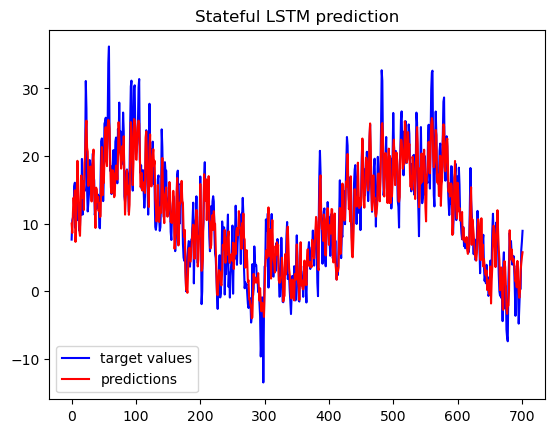

In [8]:
predictions = model.predict(test_dataset)
predictions = predictions.reshape((test_num,))

x = np.arange(test_num)
plt.plot(x, test_targets, label = 'target values', color='b')
plt.plot(x, predictions, label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()

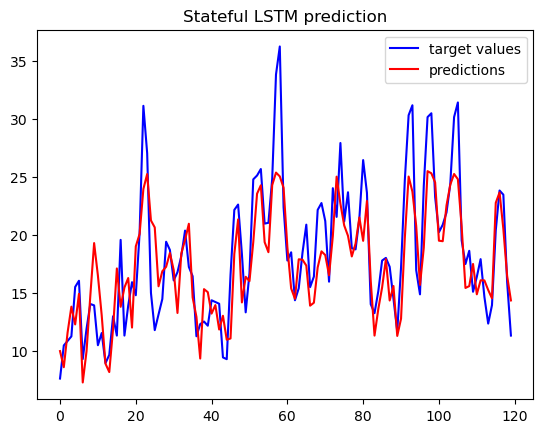

In [9]:
x = np.arange(120)
plt.plot(x, test_targets[:120], label = 'target values', color='b')
plt.plot(x, predictions[:120], label = 'predictions', color='r')
plt.title('Stateful LSTM prediction')
plt.legend()
plt.show()